In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [3]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [4]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [5]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
ds_info.features["label"].num_classes

10

In [7]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

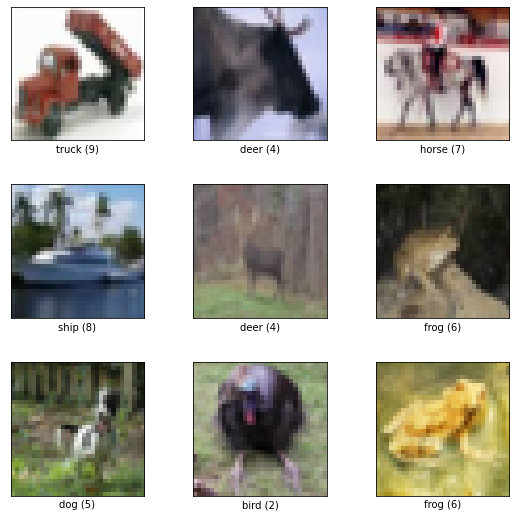

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

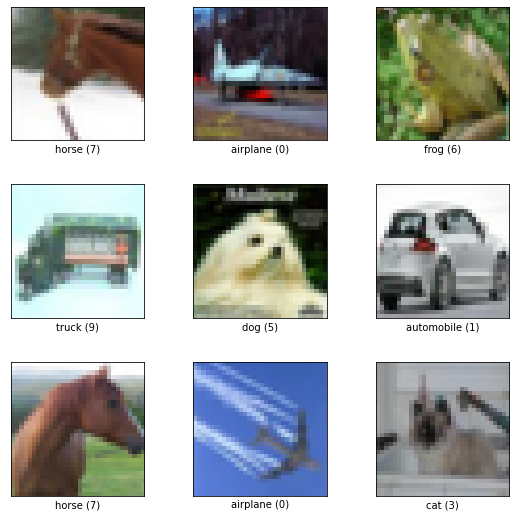

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

In [10]:
def build_resnet_block(input_layer ,num_cnn=2,stage_num=2, channel=64, Res50=False, Plain=False):
    
    x = input_layer
    short = x
  
    if not Res50:
        for cnn_num in range(num_cnn):
            if cnn_num == 0:
                if stage_num == 2:
                    stride = 1
                else:
                    stride = 2
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3, 3), 
                                        padding='same',
                                        strides=stride,
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)
                
                # plain 모델인 경우 short cut을 비활성
                if Plain == False:
                    short = keras.layers.Conv2D(filters=channel,
                                                kernel_size=(1, 1),
                                                strides=stride,
                                                padding='same',
                                                name=f'stage{stage_num}_{cnn_num+1}_short',
                                                )(short)
                    short = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(short)
                    x = keras.layers.Add()([x, short])
                
                x = keras.layers.Activation('relu')(x)

                short = x
            else:
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)

                if Plain == False:
                    x = keras.layers.Add()([x, short])

                x = keras.layers.Activation('relu')(x)

                short = x

    else:
        for cnn_num in range(num_cnn):
            if cnn_num == 0:
                
                if stage_num == 2:
                    stride = 1
                else:
                    stride = 2
                    
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        strides = stride,
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stae{stage_num}_{cnn_num+1}_bn2')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)
                
                if Plain == False:
                    short = keras.layers.Conv2D(filters=channel*4,
                                                kernel_size=(1, 1),
                                                strides=stride,
                                                padding='same',
                                                name=f'stage{stage_num}_{cnn_num+1}_short',
                                                )(short)
                    short = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn4')(short)
                    x = keras.layers.Add()([x, short])
                x = keras.layers.Activation('relu')(x)
                
                short = x
            else:
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stae{stage_num}_{cnn_num+1}_bn2')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)
                
                if Plain == False:
                    x = keras.layers.Add()([x, short])
                    
                x = keras.layers.Activation('relu')(x)
                
                short = x

                    
    return x
    

In [11]:
def build_resnet(input_shape=(224, 224, 3), Res50=False, Plain=False):
    
    num_cnn_ls = [3, 4, 6, 3]
    channel_ls = [64, 128, 256, 512]
    num_classes = 2
    
    
        
    input_layer = keras.layers.Input(shape=input_shape)

    x = input_layer
    x = keras.layers.Conv2D(filters = 64,
                            kernel_size=(7, 7),
                            strides=2,
                            kernel_initializer='he_normal',
                            padding='same',
                            name=f'conv2d_0',
                            )(x)

    x = keras.layers.BatchNormalization(name=f'batch_normalization_0')(x)
    x = keras.layers.Activation('relu', name=f'activation_0')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same', name=f'stage2_0_maxpooling')(x)
    
    output = x 
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_ls, channel_ls)):
        output = build_resnet_block(output,
                                    num_cnn=num_cnn,
                                    stage_num = i+2,
                                    channel=channel,
                                    Res50 = Res50,
                                    Plain = Plain,
                                    )

    output = keras.layers.AveragePooling2D(pool_size = 1,
                                           padding='same',
                                           name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten_6')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',name='predictions')(output)

    model = keras.Model(inputs=input_layer, outputs=output)

    return model

In [12]:
Res34 = build_resnet(Plain=False)
Res34.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,256,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [13]:
Res34Plain = build_resnet(Plain=True)
Res34Plain_plain.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

In [ ]:
Res50 = build_resnet(Res50=True, Plain=False)
Res50.summary()

In [ ]:
Res50Plain = build_resnet(Res50=True, Plain=True)
Res50Plain.summary()